In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

2025-09-20 11:55:48.212383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758369348.567502      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758369348.680014      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#Load dataset
df = pd.read_csv("/kaggle/input/walmart-dataset/Walmart.csv")

print("Shape:", df.shape)
df.head()

Shape: (6435, 8)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [7]:
sales = df.groupby("Date")['Weekly_Sales'].sum().reset_index()
sales['Date'] = pd.to_datetime(sales['Date'], dayfirst=True)
sales = sales.sort_values('Date')
sales

,Date,Weekly_Sales
19,2010-02-05,49750740.50
52,2010-02-12,48336677.63
85,2010-02-19,48276993.78
118,2010-02-26,43968571.13
20,2010-03-05,46871470.30
...,...,...
130,2012-09-28,43734899.40
22,2012-10-05,47566639.31
55,2012-10-12,46128514.25
88,2012-10-19,45122410.57


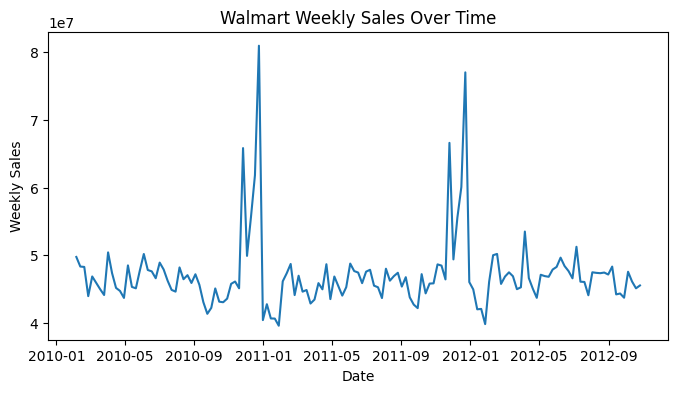

In [12]:
# Plot sales trend
plt.figure(figsize=(8,4))
plt.plot(sales['Date'], sales['Weekly_Sales'])
plt.title("Walmart Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.show()

In [13]:
# Train-Test Split
train = sales.iloc[:-20]
test = sales.iloc[-20:]

In [18]:
# ARIMA model
arima_model = ARIMA(train['Weekly_Sales'], order=(5,1,2))
arima_res = arima_model.fit()

arima_forecast = arima_res.forecast(steps=20)
arima_forecast = pd.Series(arima_forecast.values, index=test.index)

arima_mae = mean_absolute_error(test['Weekly_Sales'], arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test['Weekly_Sales'], arima_forecast))

print("ARIMA MAE:", arima_mae)
print("ARIMA RMSE:", arima_rmse)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as s

ARIMA MAE: 1620000.161122208
ARIMA RMSE: 2076691.8860985509


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [23]:
# Prepare Prophet input (train only)
prophet_df = train.rename(columns={'Date':'ds','Weekly_Sales':'y'})
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
prophet_model.fit(prophet_df)

# Create future dataframe (extend into test period)
future = prophet_model.make_future_dataframe(periods=len(test), freq='W')
forecast = prophet_model.predict(future)

# Take only the last len(test) predictions (aligned with test set)
prophet_pred = forecast['yhat'].iloc[-len(test):].values
prophet_actual = test['Weekly_Sales'].values

# Evaluate
prophet_mae = mean_absolute_error(prophet_actual, prophet_pred)
prophet_rmse = np.sqrt(mean_squared_error(prophet_actual, prophet_pred))

print("Prophet MAE:", prophet_mae)
print("Prophet RMSE:", prophet_rmse)


12:27:27 - cmdstanpy - INFO - Chain [1] start processing
12:27:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE: 2494361.6512681586
Prophet RMSE: 2745897.8831992815


In [38]:
# LSTM Model
series = sales.set_index('Date')['Weekly_Sales']

# Scale
scaler = MinMaxScaler()
scaled = scaler.fit_transform(series.values.reshape(-1,1))

# Create sequences
def create_sequences(data, n_steps=10):
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 10
X, y = create_sequences(scaled, n_steps)
split = int(0.8*len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(n_steps,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

lstm_pred = model.predict(X_test)
lstm_pred_inv = scaler.inverse_transform(lstm_pred)

y_test_inv = scaler.inverse_transform(y_test)

lstm_mae = mean_absolute_error(y_test_inv, lstm_pred_inv)
lstm_rmse = np.sqrt(mean_squared_error(y_test_inv, lstm_pred_inv))
print("LSTM MAE :",lstm_mae)
print("LSTM RMSE :",lstm_rmse)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
LSTM MAE : 1347704.4340740752
LSTM RMSE : 1764166.259086239


In [42]:
# Compare Results
print(f"ARIMA = MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}")
print(f"Prophet = MAE: {prophet_mae:.2f}, RMSE: {prophet_rmse:.2f}")
print(f"LSTM = MAE: {lstm_mae:.2f}, RMSE: {lstm_rmse:.2f}")

ARIMA = MAE: 1620000.16, RMSE: 2076691.89
Prophet = MAE: 2494361.65, RMSE: 2745897.88
LSTM = MAE: 1347704.43, RMSE: 1764166.26


          Date       Actual         ARIMA       Prophet
67  2012-06-15  48412110.70  4.875403e+07  5.064361e+07
100 2012-06-22  47668284.97  4.859684e+07  5.127499e+07
133 2012-06-29  46597112.12  4.820852e+07  5.138466e+07
27  2012-07-06  51253021.88  4.823537e+07  5.053432e+07
60  2012-07-13  46099732.10  4.768018e+07  4.934665e+07


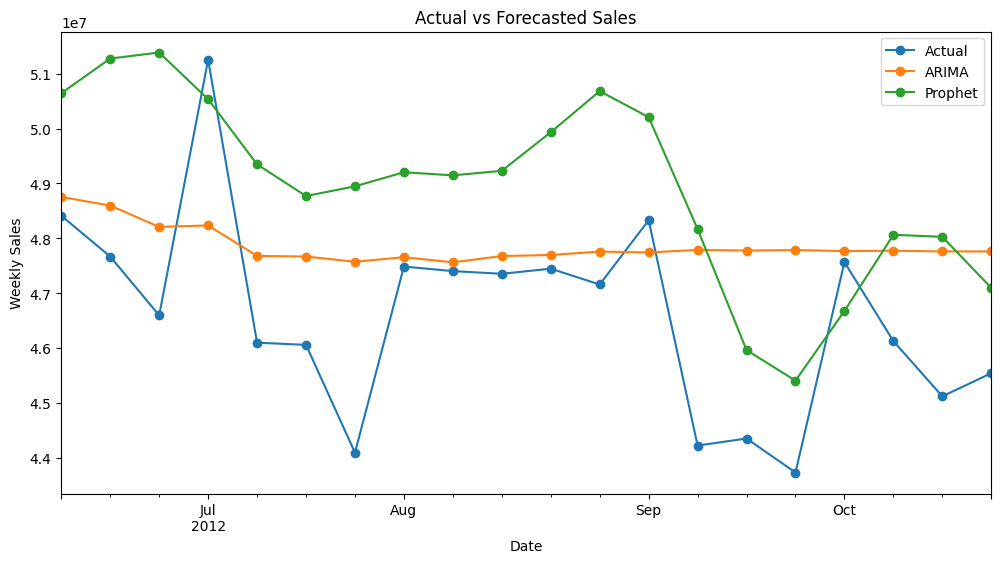

In [51]:
# Ensure ARIMA forecast length matches test set
arima_forecast_aligned = arima_forecast[:len(test)]

# Ensure Prophet forecast length matches test set
prophet_pred_aligned = prophet_pred[:len(test)]

# Create DataFrame for comparison
df_plot = pd.DataFrame({
    'Date': test['Date'].values,
    'Actual': test['Weekly_Sales'].values,
    'ARIMA': arima_forecast_aligned,
    'Prophet': prophet_pred_aligned
})

print(df_plot.head())

# Plot comparison
df_plot.plot(x='Date', y=['Actual','ARIMA','Prophet'], figsize=(12,6), marker='o')
plt.title("Actual vs Forecasted Sales")
plt.ylabel("Weekly Sales")
plt.show()
